<center>

### COSC2753 - Machine Learning

# **Model Evaluation & Selection**

<center>────────────────────────────</center>
&nbsp;


# I. Problem Statement

This notebook explores the process of evaluating and selecting the optimal model for a given dataset. The analysis will leverage a preprocessed dataset where the target variable, `Status,` is a binary classification problem (0 or 1). To assess model performance, F1-score and AUC-ROC curve will be employed. The following models will be evaluated:

1. **Logistic Regression (LR1- Polynomial Degree 1, LR2- Polynomial Degree 2)**
2. **Decision Tree**
3. **Random Forest**

At the end, the best model will be selected based on the evaluation metrics.


# II. Global Configuration

In [23]:
import sys
import importlib
import tabulate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import sklearn
import statsmodels
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import FitFailedWarning
import warnings
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Reload modules
sys.path.append("../../")  # Root directory
modules_to_reload = [
    "scripts.styler",
    "scripts.neko",
    "scripts.utils",
    "scripts.outlier_detector",
]

# Reload modules if they have been modified
missing_modules = []

for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])
    else:
        missing_modules.append(module_name)

# Recache missing modules
if missing_modules:
    print(f"Modules {missing_modules} not found. \nRecaching...")

# Import user-defined scripts
from scripts.styler import Styler
from scripts.neko import Neko
from scripts.utils import Utils
from scripts.outlier_detector import OutlierDetector

# Initialize styler
styler = Styler()  # Text Styler

# Check package versions
styler.draw_box("Validating Package Versions...")

try:
    with open("../../requirements.txt", "r") as file:
        requirements = file.readlines()
except FileNotFoundError:
    print(f"File '../../requirements.txt' not found. Please check your directory!")

packages_to_check = [np, pd, sns, matplotlib, tabulate, sklearn, statsmodels, imblearn]

for package in packages_to_check:
    Utils.version_check(package, requirements=requirements)

styled_text = styler.style("\nDone validating packages\n", bold=True, italic=True)
print(styled_text)

# Initialize objects
styler.draw_box("Initializing Project...")
neko = Neko()  # Panda extension
bullet = ">>>"  # Bullet point
plt = matplotlib.pyplot  # Matplotlib

# Configuration
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.precision", 3)

styled_text = styler.style("Done initializing project...", bold=True, italic=True)
print(styled_text)

┌──────────────────────────────────┐
│  Validating Package Versions...  │
└──────────────────────────────────┘
>>> numpy is up to date: 1.26.4
>>> pandas is up to date: 2.2.1
>>> seaborn is up to date: 0.13.2
>>> matplotlib is up to date: 3.8.3
>>> tabulate is up to date: 0.9.0
>>> sklearn is up to date: 1.4.1.post1
>>> statsmodels is up to date: 0.14.1
>>> imblearn is up to date: 0.12.2

Done validating packages

┌───────────────────────────┐
│  Initializing Project...  │
└───────────────────────────┘

    /\_____/\
   /  x   o  \
  ( ==  ^  == )       Neko has arrived!
   )         (        An data visualizing extension for analyzing DataFrames.
  (           )       Art: https://www.asciiart.eu/animals/cats.
 ( (  )   (  ) )
(__(__)___(__)__)

Done initializing project...


# III. Data Loading

In [24]:
try:
    # Load data
    df_train = pd.read_csv("../../data/processed/data_train_processed.csv")

    styler.draw_box("Data Loaded Successfully")

except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
except Exception as e:
    print("An error occurred:", e)

┌────────────────────────────┐
│  Data Loaded Successfully  │
└────────────────────────────┘


# IV. Model Comparison

### 1.1 Logistic Regression

In [25]:
# Specify the columns to include
columns_to_include = [
    "HighBP",
    "HighChol",
    "CholCheck",
    "BMI",
    "Stroke",
    "HeartDiseaseorAttack",
    "HvyAlcoholConsump",
    "NoDocbcCost",
    "GenHlth",
    "MentHlth",
    "PhysHlth",
    "DiffWalk",
    "Sex",
    "Age",
    "Education",
    "Income",
    "ExtraMedTest",
    "ExtraAlcoholTest",
    "Status",
]

# Keep only the specified columns in df_logis
df_logis = df_train[columns_to_include]

# Normalising data
df_logis = neko.scale_feature(df_logis, "norm")

df_logis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71262 entries, 0 to 71261
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HighBP                71262 non-null  float64
 1   HighChol              71262 non-null  float64
 2   CholCheck             71262 non-null  float64
 3   BMI                   71262 non-null  float64
 4   Stroke                71262 non-null  float64
 5   HeartDiseaseorAttack  71262 non-null  float64
 6   HvyAlcoholConsump     71262 non-null  float64
 7   NoDocbcCost           71262 non-null  float64
 8   GenHlth               71262 non-null  float64
 9   MentHlth              71262 non-null  float64
 10  PhysHlth              71262 non-null  float64
 11  DiffWalk              71262 non-null  float64
 12  Sex                   71262 non-null  float64
 13  Age                   71262 non-null  float64
 14  Education             71262 non-null  float64
 15  Income             

In [26]:
# Warning suppression
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Split the data into training and testing sets
X = df_logis.drop(columns=["Status"], axis=1)
y = df_logis["Status"]

X_train_logis, X_test_logis, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [27]:
degrees = range(1, 3)

best_logis = {
    1: {
        "best_model": LogisticRegression(
            C=2.976351441631316,
            l1_ratio=0.5555555555555556,
            max_iter=2500,
            random_state=42,
        ),
        "best_params": {
            "C": 2.976351441631316,
            "l1_ratio": 0.5555555555555556,
            "max_iter": 2500,
            "penalty": "l2",
            "solver": "lbfgs",
        },
    },
    2: {
        "best_model": LogisticRegression(
            C=1.438449888287663,
            l1_ratio=0.7777777777777777,
            max_iter=5000,
            penalty="l1",
            random_state=42,
            solver="liblinear",
        ),
        "best_params": {
            "C": 1.438449888287663,
            "l1_ratio": 0.7777777777777777,
            "max_iter": 5000,
            "penalty": "l1",
            "solver": "liblinear",
        },
    },
}

for degree in degrees:
    styler.draw_box(f"Evaluating the best model for degree {degree}")

    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_logis)
    X_test_poly = poly_features.transform(X_test_logis)

    neko.evaluate_model(
        best_logis[degree]["best_model"],
        X_train_poly,
        y_train,
        X_test_poly,
        y_test,
    )

┌──────────────────────────────────────────┐
│  Evaluating the best model for degree 1  │
└──────────────────────────────────────────┘
Classification Report for Training Data:
               precision    recall  f1-score   support

         0.0       0.79      0.84      0.81     28473
         1.0       0.83      0.77      0.80     28536

    accuracy                           0.81     57009
   macro avg       0.81      0.81      0.81     57009
weighted avg       0.81      0.81      0.81     57009

Classification Report for Testing Data:
               precision    recall  f1-score   support

         0.0       0.78      0.84      0.81      7158
         1.0       0.83      0.76      0.79      7095

    accuracy                           0.80     14253
   macro avg       0.80      0.80      0.80     14253
weighted avg       0.80      0.80      0.80     14253

┌──────────────────────────────────────────┐
│  Evaluating the best model for degree 2  │
└─────────────────────────────────────

### 1.2 Tree-based Models

In [28]:
# Split the data into training and testing sets
X = df_logis.drop(columns=["Status"], axis=1)
y = df_logis["Status"]

X_train_tree, X_test_tree, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [29]:
best_decision_tree = DecisionTreeClassifier(
    max_depth=13, min_samples_leaf=2, min_samples_split=18, random_state=42
)

neko.evaluate_model(best_decision_tree, X_train_tree, y_train, X_test_tree, y_test)

Classification Report for Training Data:
               precision    recall  f1-score   support

         0.0       0.86      0.91      0.88     28473
         1.0       0.91      0.85      0.88     28536

    accuracy                           0.88     57009
   macro avg       0.88      0.88      0.88     57009
weighted avg       0.88      0.88      0.88     57009

Classification Report for Testing Data:
               precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      7158
         1.0       0.88      0.82      0.85      7095

    accuracy                           0.86     14253
   macro avg       0.86      0.86      0.86     14253
weighted avg       0.86      0.86      0.86     14253



In [30]:
best_random_forrest = RandomForestClassifier(
    n_estimators=225,
    min_samples_split=17,
    min_samples_leaf=4,
    max_features=None,
    max_depth=40,
    criterion="entropy",
    ccp_alpha=0.0,
)

neko.evaluate_model(best_random_forrest, X_train_tree, y_train, X_test_tree, y_test)

Classification Report for Training Data:
               precision    recall  f1-score   support

         0.0       0.91      0.96      0.93     28473
         1.0       0.95      0.90      0.93     28536

    accuracy                           0.93     57009
   macro avg       0.93      0.93      0.93     57009
weighted avg       0.93      0.93      0.93     57009

Classification Report for Testing Data:
               precision    recall  f1-score   support

         0.0       0.85      0.90      0.87      7158
         1.0       0.89      0.83      0.86      7095

    accuracy                           0.87     14253
   macro avg       0.87      0.87      0.87     14253
weighted avg       0.87      0.87      0.87     14253



## 1.3 ROC - Curve

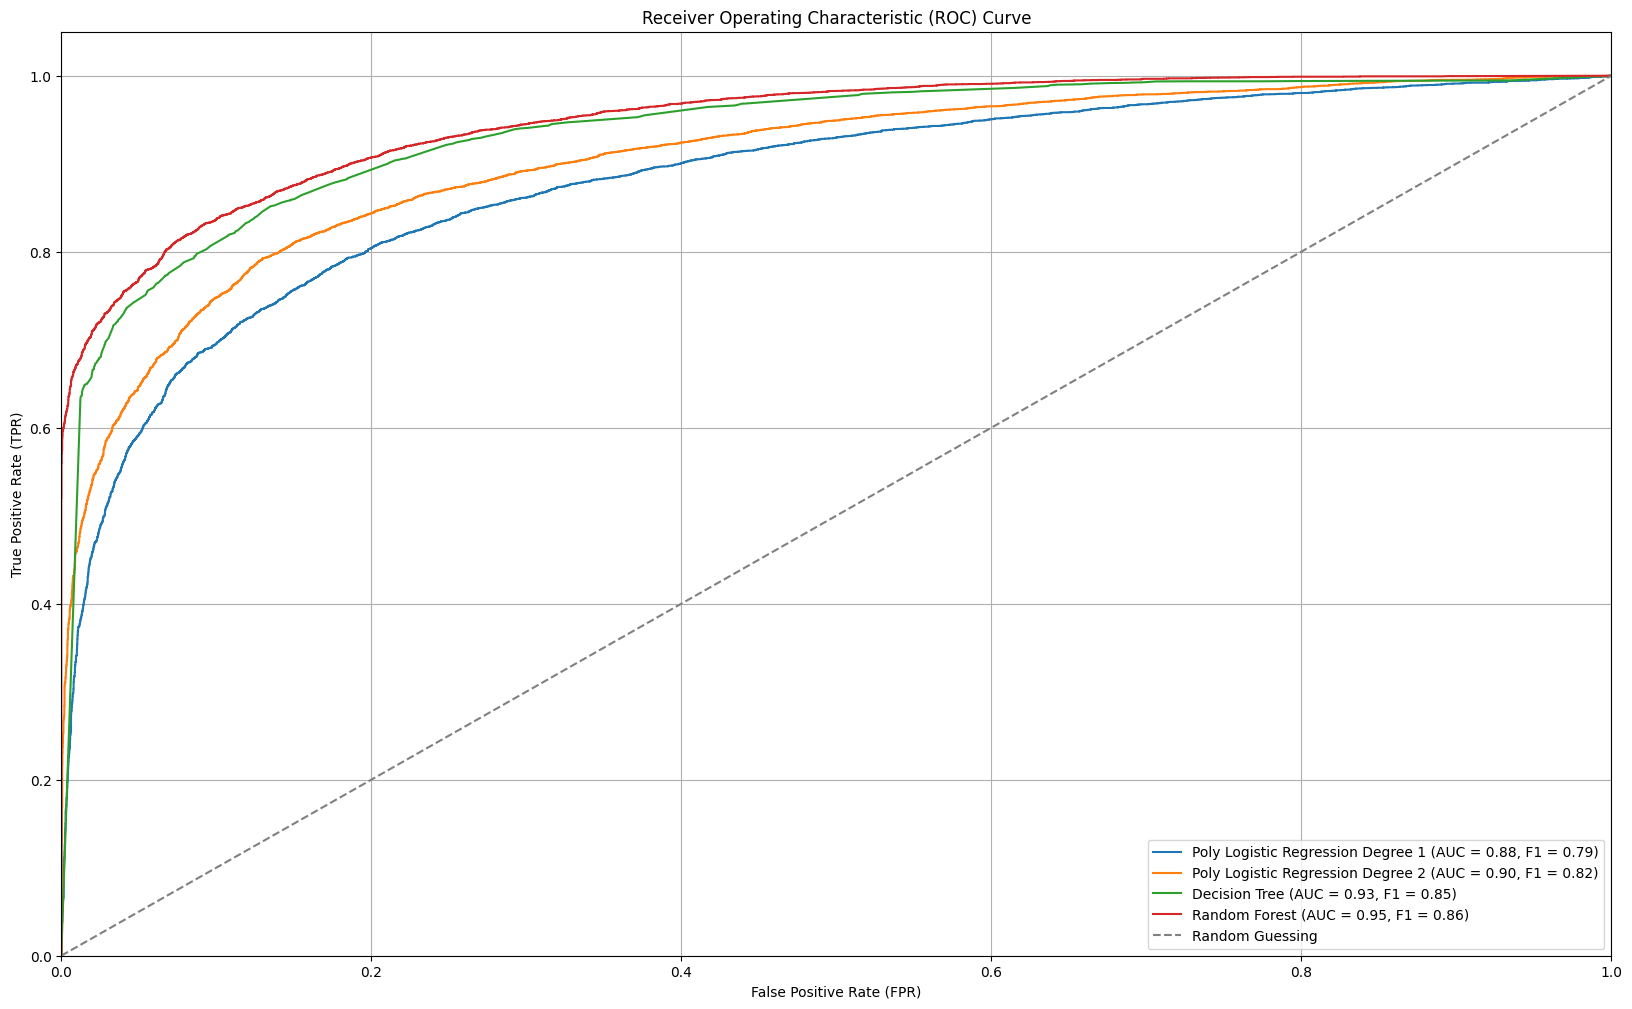

In [31]:
models = [
    best_logis[1]["best_model"],
    best_logis[2]["best_model"],
    best_decision_tree,
    best_random_forrest,
]

poly_1 = PolynomialFeatures(1)
X_test_logis_poly_1 = poly_1.fit_transform(X_test_logis)

poly_2 = PolynomialFeatures(2)
X_test_logis_poly_2 = poly_2.fit_transform(X_test_logis)

# Plot ROC curve for each model
plt.figure(figsize=(20, 12))

for i, model in enumerate(models):
    if i == 0:
        X_test = X_test_logis_poly_1
        model_name = "Poly Logistic Regression Degree 1"
    elif i == 1:
        X_test = X_test_logis_poly_2
        model_name = "Poly Logistic Regression Degree 2"
    elif i == 2:
        X_test = X_test_tree
        model_name = "Decision Tree"
    else:
        X_test = X_test_tree
        model_name = "Random Forest"

    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # F1 Score
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f}, F1 = {f1:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## **Conclusion**

Dr. Bao defines a good accuracy range to be between **85%** and **92%**. While the two Polynomial Logistic Regression models achieved reasonable accuracy, they were excluded from further consideration.

When comparing the Decision Tree and Random Forest models, the Random Forest model exhibited a superior F1-score and AUC-ROC value. Consequently, the Random Forest model was chosen as the final model for the dataset. It is important to note that the Random Forest model exhibited a slight discrepancy (**6%**) between the training and validation data accuracy. However, this difference is considered acceptable.
